In [1]:
# !nvidia-smi
!pip install transformers hazm datasets

  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154584 sha256=4d964f9b016d63f8a23e872666f29a0497999d53a745b21e3d22fe0a20469f3f
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
  Created wheel for nltk: filename=nltk-3.3-cp37-none-any.whl size=1394485 sha256=036a95629b612fce315dcaa74114d88ab57aa532dbfc9a3031537bdf826ffa2c
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built libwapiti nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:
raw_train_df = pd.read_csv("./drive/MyDrive/2/train_set.csv")
test_df = pd.read_csv("./drive/MyDrive/2/test_set.csv")

In [5]:
labels = sorted(list(raw_train_df["label"].value_counts().keys()))

In [6]:
import hazm
import re 

hazm_normalizer = hazm.Normalizer()

def normalize(desc):
    desc = re.sub("\d+", "", desc) # remove digits
    desc = re.sub("<.*?>", " ", desc)
    desc = re.sub("[^\w\s]", " ", desc)
    desc = re.sub("\s", " ", desc)
    desc = re.sub("[a-zA-Z]", " ", desc)
    desc = hazm_normalizer.normalize(desc)
    return desc.strip(" \u200c")

In [8]:
raw_train_df["normal_desc"] = raw_train_df["description_fa"].apply(normalize)
test_df["normal_desc"] = test_df["description_fa"].apply(normalize)

In [9]:
test_df["label"] = np.zeros((len(test_df), 1))

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(raw_train_df, test_size=0.1, random_state=1, shuffle=True)

In [11]:
from datasets import Dataset, DatasetDict, Features, Sequence, ClassLabel, Value

def create_dataset(df):
    return Dataset.from_dict(
        {
            "desc": df.loc[:, "normal_desc"],
            "label": df.loc[:, "label"]
        }, features=Features(
            {
                "desc": Value(dtype='string', id=None),
                "label": ClassLabel(num_classes=len(labels), names=labels, names_file=None, id=None)
            }))

In [12]:
train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds})

dataset

DatasetDict({
    train: Dataset({
        features: ['desc', 'label'],
        num_rows: 34109
    })
    validation: Dataset({
        features: ['desc', 'label'],
        num_rows: 3790
    })
    test: Dataset({
        features: ['desc', 'label'],
        num_rows: 10000
    })
})

In [13]:
# MODEL_CHECKPOINT = "HooshvareLab/distilbert-fa-zwnj-base"
# MODEL_CHECKPOINT = "HooshvareLab/bert-fa-zwnj-base"
MODEL_CHECKPOINT = "HooshvareLab/roberta-fa-zwnj-base"

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, use_fast=True)

In [15]:
def encode_data(data):
    return tokenizer(data["desc"], truncation=True)

In [16]:
encoded_dataset = dataset.map(encode_data, batched=True)

In [17]:
from transformers import AutoModelForSequenceClassification

EPOCH = 5
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=len(labels))

Some weights of the model checkpoint at HooshvareLab/roberta-fa-zwnj-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['classifier.out_proj.weight', '

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", pos_label=None)
    return {
        'accuracy': (precision + recall) / 2,
    }

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    f"test_label",
    evaluation_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    load_best_model_at_end=True,
    warmup_steps=500,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,  
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    metric_for_best_model="accuracy",
    logging_dir="log"
)

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,  
    args=training_args, 
    train_dataset=encoded_dataset["train"],  
    eval_dataset=encoded_dataset["validation"],  
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# import torch
# torch.cuda.empty_cache()

In [ ]:
trainer.evaluate()

In [ ]:
predict = trainer.predict(encoded_dataset["test"])
test_df["label"] = list(map(lambda i: labels[i], predict.predictions.argmax(-1)))

Epoch,Training Loss,Validation Loss,Accuracy
1,0.312400,1.054080,0.749664
2,0.203900,1.197839,0.751494


In [ ]:
test_df.loc[:, ["app_id", "label"]].to_csv("./drive/MyDrive/2/text_pred.csv", encoding='utf-8', index=False)

In [ ]:
predict = trainer.predict(encoded_dataset["validation"])
val_df["prediction"] = list(map(lambda i: labels[i], predict.predictions.argmax(-1)))

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm)

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(18, 18))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

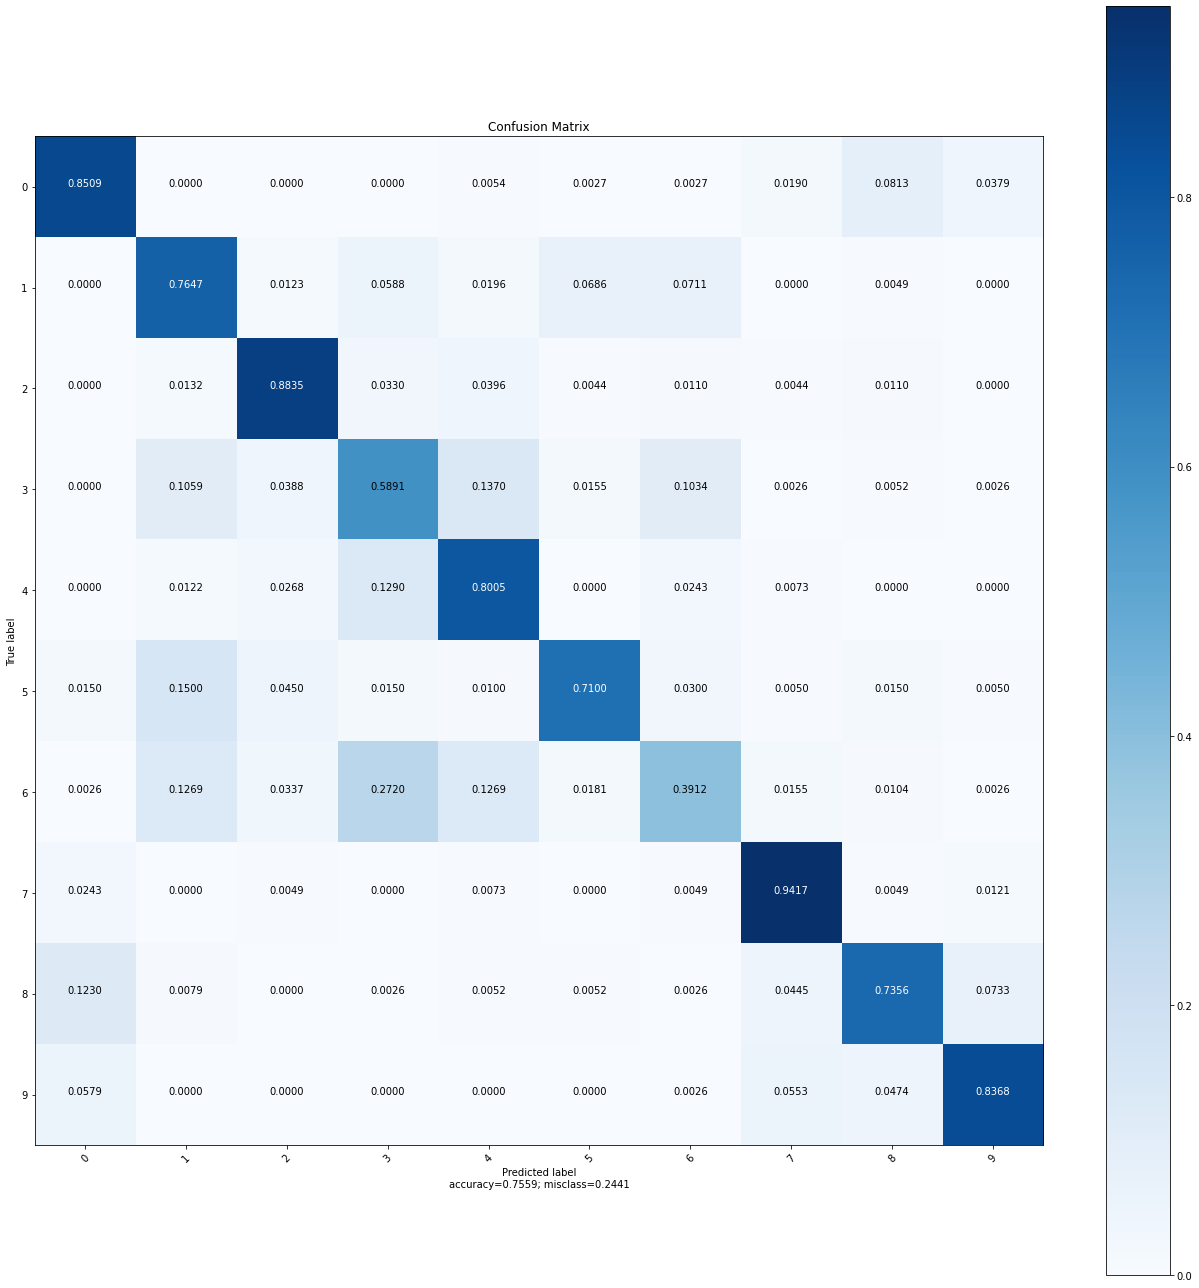

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(val_df["label"], val_df["prediction"], labels=labels)
plot_confusion_matrix(cm=conf_matrix, normalize=True, target_names=labels, title="Confusion Matrix")